## Problem statement:
### A significant public health concern is the rising cost of healthcare. Therefore, it's crucial to be able to predict future costs and gain a solid understanding of their causes. 

## Objective:
### The objective of this project is to predict patients’ healthcare costs and to identify factors contributing to this prediction. 

In [225]:
# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# warnings
import warnings
warnings.simplefilter('ignore')

## -- Reading data from all the datasets

In [298]:
df1=pd.read_csv('Documents/Simplilearn Course/Datasets (1)/Capstone_1/Hospitalisation details.csv')
df1.head(2)

,Customer ID,year,month,date,children,charges,Hospital tier,City tier,State ID
0,Id2335,1992,Jul,9,0,563.84,tier - 2,tier - 3,R1013
1,Id2334,1992,Nov,30,0,570.62,tier - 2,tier - 1,R1013


In [299]:
df2=pd.read_csv('Documents/Simplilearn Course/Datasets (1)/Capstone_1/Medical Examinations.csv')
df2.head(2)

,Customer ID,BMI,HBA1C,Heart Issues,Any Transplants,Cancer history,NumberOfMajorSurgeries,smoker
0,Id1,47.41,7.47,No,No,No,No major surgery,yes
1,Id2,30.36,5.77,No,No,No,No major surgery,yes


In [300]:
df3=pd.read_excel('Documents/Simplilearn Course/Datasets (1)/Capstone_1/Names.xlsx')
df3.head(2)

,Customer ID,name
0,Id1,"Hawks, Ms. Kelly"
1,Id2,"Lehner, Mr. Matthew D"


In [301]:
print(df1.shape)
print(df2.shape)
print(df3.shape)

(2343, 9)
(2335, 8)
(2335, 2)


In [302]:
df1.duplicated().sum()

0

## --Combining all the files using merge, so that all the information is in one place. key column is to be join is Customer ID.

In [303]:
# Merge Dataframes on Customer ID coloumn
merged_df=pd.merge(df1,df2,on='Customer ID',how='outer')
merged_df=pd.merge(merged_df,df3,on='Customer ID',how='outer')
merged_df.head(2)

,Customer ID,year,month,date,children,charges,Hospital tier,City tier,State ID,BMI,HBA1C,Heart Issues,Any Transplants,Cancer history,NumberOfMajorSurgeries,smoker,name
0,Id2335,1992,Jul,9,0,563.84,tier - 2,tier - 3,R1013,17.58,4.51,No,No,No,1,No,"German, Mr. Aaron K"
1,Id2334,1992,Nov,30,0,570.62,tier - 2,tier - 1,R1013,17.60,4.39,No,No,No,1,No,"Rosendahl, Mr. Evan P"


In [304]:
merged_df.shape

(2343, 17)

In [305]:
merged_df.nunique()

Customer ID               2338
year                        48
month                        8
date                        30
children                     6
charges                   2333
Hospital tier                4
City tier                    4
State ID                    17
BMI                       1335
HBA1C                      667
Heart Issues                 2
Any Transplants              2
Cancer history               2
NumberOfMajorSurgeries       4
smoker                       3
name                      2335
dtype: int64

In [306]:
merged_df.drop_duplicates(inplace=True)

In [307]:
merged_df.shape

(2343, 17)

## -- Finding the percentage of rows that have trivial value (for example, ?), and delete such rows if they do not contain significant information

In [308]:
# Replace '?' with NaN
merged_df.replace('?',pd.NA,inplace=True)

# Create a boolean mask for trivial values
trivial_mask=merged_df.applymap(lambda x:x=='?')

In [309]:
trivial_mask.head(2)

,Customer ID,year,month,date,children,charges,Hospital tier,City tier,State ID,BMI,HBA1C,Heart Issues,Any Transplants,Cancer history,NumberOfMajorSurgeries,smoker,name
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [310]:
# Count the number of rows for trivial value
trivial_rows_count=trivial_mask.any(axis=1).sum()
trivial_rows_count

0

In [311]:
percentage_trivial_rows=(trivial_rows_count/len(merged_df))*100
print(f'percentage of rows with trivial values: {percentage_trivial_rows:.2f}%')

percentage of rows with trivial values: 0.00%


#### ** Above we replaced  '?' with pd.NaN and created boolean mask for trivial values,  and lastly found percentage of the rows with trivial values 

## -- Checking for missing values in the dataset

In [312]:
merged_df.isnull().sum()

Customer ID                6
year                       2
month                      3
date                       0
children                   0
charges                    0
Hospital tier              1
City tier                  1
State ID                   2
BMI                        8
HBA1C                      8
Heart Issues               8
Any Transplants            8
Cancer history             8
NumberOfMajorSurgeries     8
smoker                    10
name                       8
dtype: int64

#### **There are missing values in data we have to treat this missing values

In [313]:
merged_df.dropna(subset=['Customer ID','year','month','Hospital tier','City tier','State ID','BMI','HBA1C','Heart Issues',
                         'Any Transplants','Cancer history','NumberOfMajorSurgeries','smoker','name'],inplace=True)

In [314]:
merged_df.isnull().sum()

Customer ID               0
year                      0
month                     0
date                      0
children                  0
charges                   0
Hospital tier             0
City tier                 0
State ID                  0
BMI                       0
HBA1C                     0
Heart Issues              0
Any Transplants           0
Cancer history            0
NumberOfMajorSurgeries    0
smoker                    0
name                      0
dtype: int64

In [315]:
merged_df.shape

(2325, 17)

#### **Now no null values in dataset we treat it by deleting rows which have null values....The other way to teat null values is by replacing with median and mode, but here we don't have huge amount of null values in each column so we dropped the rows which contains null value. 

## -- The dataset has State ID, which has around 16 states. All states are not represented in equal proportions in the data. Creating dummy variables for all regions may also result in too many insignificant predictors. Nevertheless, only R1011, R1012, and R1013 are worth investigating further. Creating a suitable strategy to create dummy variables with these restraints.

In [316]:
merged_df['State ID'].value_counts()

R1013    609
R1011    574
R1012    572
R1024    159
R1026     84
R1021     70
R1016     64
R1025     40
R1023     38
R1017     36
R1019     26
R1022     14
R1014     13
R1015     11
R1018      9
R1020      6
Name: State ID, dtype: int64

In [317]:
merged_df['State ID'].nunique()

16

In [318]:
merged_df.replace(['R1024','R1026','R1021','R1016','R1025','R1023','R1017','R1019','R1022','R1014','R1015','R1018','R1020'],
                  'others',inplace=True)

In [319]:
merged_df['State ID'].value_counts()

R1013     609
R1011     574
R1012     572
others    570
Name: State ID, dtype: int64

In [320]:
merged_df.replace('R1011',0,inplace=True)
merged_df.replace('R1012',1,inplace=True)
merged_df.replace('R1013',2,inplace=True)
merged_df.replace('others',3,inplace=True)

#### **Except R1013,R1012,R1011 state ID's we combined all other state ID's and put them in one ID named as 'other'.
#### **filtered all the state id a part from 3 having maximum occurences and put in under new state_id name  as 'other', now there are 4 unique state id's.
#### **and replaced R1011 with 0, R1012 with 1, R1013 with 2 and others with 3.

## --- The variable NumberOfMajorSurgeries also appears to have string values. Apply a suitable method to clean up this variable.

In [321]:
merged_df['NumberOfMajorSurgeries'].unique()

array(['1', 'No major surgery', '2', '3'], dtype=object)

In [322]:
merged_df.replace(['No major surgery'],0,inplace=True)

In [323]:
merged_df['NumberOfMajorSurgeries']=merged_df['NumberOfMajorSurgeries'].astype('int64')

In [324]:
merged_df['NumberOfMajorSurgeries'].unique()

array([1, 0, 2, 3], dtype=int64)

#### **Above we replaced the value 'No major surgery' with 0.
#### **And the column 'NumberOfMajorSurgeries' is object datatype, so converted this column into int64 by using astype(int64).

## -- Shows the HBA1C report (HBA1C measures the amount of sugar in the blood (glucose), where HBA1C greater than 6.5 is considered diabetic assuming as 1 and less than 6.5 is considered as non-diabetic assuming as 0

In [325]:
merged_df["HBA1C"] = np.where(merged_df["HBA1C"] > 6.5, 1.0, 0)
merged_df["HBA1C"]=merged_df["HBA1C"].astype('int64')
merged_df.rename(columns = {'HBA1C':'Diabetic'}, inplace = True) 
merged_df.head(2)

,Customer ID,year,month,date,children,charges,Hospital tier,City tier,State ID,BMI,Diabetic,Heart Issues,Any Transplants,Cancer history,NumberOfMajorSurgeries,smoker,name
0,Id2335,1992,Jul,9,0,563.84,tier - 2,tier - 3,2,17.58,0,No,No,No,1,No,"German, Mr. Aaron K"
1,Id2334,1992,Nov,30,0,570.62,tier - 2,tier - 1,2,17.60,0,No,No,No,1,No,"Rosendahl, Mr. Evan P"


#### **Above  HBA1C column values changed with 1(diabetic) if HBA1C is greater than 6.5 and with 0(non-diabetic) if HBA1C is less than 6.5.

## -- Age appears to be a significant factor in this analysis. Calculate the patients' ages based on their dates of birth

#### ** year,month and date columns are object datatype converting them into datetime datatype

In [326]:
merged_df['year']=pd.to_datetime(merged_df['year'])
merged_df['month']=pd.to_datetime(merged_df['month'],format='%b')
merged_df['date']=pd.to_datetime(merged_df['date'],format='%d',errors='coerce')

In [327]:
merged_df.dtypes

Customer ID                       object
year                      datetime64[ns]
month                     datetime64[ns]
date                      datetime64[ns]
children                           int64
charges                          float64
Hospital tier                     object
City tier                         object
State ID                           int64
BMI                              float64
Diabetic                           int64
Heart Issues                      object
Any Transplants                   object
Cancer history                    object
NumberOfMajorSurgeries             int64
smoker                            object
name                              object
dtype: object

In [328]:
merged_df.head(2)

,Customer ID,year,month,date,children,charges,Hospital tier,City tier,State ID,BMI,Diabetic,Heart Issues,Any Transplants,Cancer history,NumberOfMajorSurgeries,smoker,name
0,Id2335,1992-01-01,1900-07-01,1900-01-09,0,563.84,tier - 2,tier - 3,2,17.58,0,No,No,No,1,No,"German, Mr. Aaron K"
1,Id2334,1992-01-01,1900-11-01,1900-01-30,0,570.62,tier - 2,tier - 1,2,17.60,0,No,No,No,1,No,"Rosendahl, Mr. Evan P"


#### **ofter converting, extract particular year,month and day from those columns and assign them into new columns respectively

In [329]:
from datetime import date

In [330]:
merged_df['Year']=merged_df['year'].apply(lambda x:int(x.year))

In [331]:
merged_df['Month']=merged_df['month'].apply(lambda x:int(x.month))

In [332]:
merged_df['Date']=merged_df['date'].apply(lambda x:int(x.day))

In [333]:
merged_df.head(2)

,Customer ID,year,month,date,children,charges,Hospital tier,City tier,State ID,BMI,Diabetic,Heart Issues,Any Transplants,Cancer history,NumberOfMajorSurgeries,smoker,name,Year,Month,Date
0,Id2335,1992-01-01,1900-07-01,1900-01-09,0,563.84,tier - 2,tier - 3,2,17.58,0,No,No,No,1,No,"German, Mr. Aaron K",1992,7,9
1,Id2334,1992-01-01,1900-11-01,1900-01-30,0,570.62,tier - 2,tier - 1,2,17.60,0,No,No,No,1,No,"Rosendahl, Mr. Evan P",1992,11,30


In [334]:
merged_df.dtypes

Customer ID                       object
year                      datetime64[ns]
month                     datetime64[ns]
date                      datetime64[ns]
children                           int64
charges                          float64
Hospital tier                     object
City tier                         object
State ID                           int64
BMI                              float64
Diabetic                           int64
Heart Issues                      object
Any Transplants                   object
Cancer history                    object
NumberOfMajorSurgeries             int64
smoker                            object
name                              object
Year                               int64
Month                              int64
Date                               int64
dtype: object

#### **dropping old year, month and date columns

In [335]:
merged_df=merged_df.drop(columns=['year','month','date'])

In [336]:
merged_df.head(2)

,Customer ID,children,charges,Hospital tier,City tier,State ID,BMI,Diabetic,Heart Issues,Any Transplants,Cancer history,NumberOfMajorSurgeries,smoker,name,Year,Month,Date
0,Id2335,0,563.84,tier - 2,tier - 3,2,17.58,0,No,No,No,1,No,"German, Mr. Aaron K",1992,7,9
1,Id2334,0,570.62,tier - 2,tier - 1,2,17.60,0,No,No,No,1,No,"Rosendahl, Mr. Evan P",1992,11,30


#### **Now combining all three columns(year,month and date) into one column as Date_of_ Birth

In [337]:
merged_df['Date_of_Birth']=merged_df.apply(lambda row:pd.to_datetime(f"{row['Year']}-{row['Month']}-{row['Date']}",
                                                                     errors='coerce'),axis=1)

In [338]:
merged_df.head(2)

,Customer ID,children,charges,Hospital tier,City tier,State ID,BMI,Diabetic,Heart Issues,Any Transplants,Cancer history,NumberOfMajorSurgeries,smoker,name,Year,Month,Date,Date_of_Birth
0,Id2335,0,563.84,tier - 2,tier - 3,2,17.58,0,No,No,No,1,No,"German, Mr. Aaron K",1992,7,9,1992-07-09
1,Id2334,0,570.62,tier - 2,tier - 1,2,17.60,0,No,No,No,1,No,"Rosendahl, Mr. Evan P",1992,11,30,1992-11-30


#### **caluculating age by substracting  Date_of_Birth from current_datetime and assigning age to the new column as age

In [339]:
from datetime import datetime
current_datetime=datetime.now()
current_datetime

datetime.datetime(2024, 8, 4, 21, 44, 35, 400302)

In [340]:
merged_df['age']=(current_datetime - merged_df['Date_of_Birth']).dt.days//365
merged_df.head(2)

,Customer ID,children,charges,Hospital tier,City tier,State ID,BMI,Diabetic,Heart Issues,Any Transplants,Cancer history,NumberOfMajorSurgeries,smoker,name,Year,Month,Date,Date_of_Birth,age
0,Id2335,0,563.84,tier - 2,tier - 3,2,17.58,0,No,No,No,1,No,"German, Mr. Aaron K",1992,7,9,1992-07-09,32
1,Id2334,0,570.62,tier - 2,tier - 1,2,17.60,0,No,No,No,1,No,"Rosendahl, Mr. Evan P",1992,11,30,1992-11-30,31


#### **df['date_of_birth']).dt.days calculates the difference in days, and then // 365 converts it to years. This approach handles missing or invalid values gracefully.

## --The gender of the patient may be an important factor in determining the cost of hospitalization. The salutations in a beneficiary's name can be used to determine their gender. Make a new field for the beneficiary's gender.

In [341]:
merged_df['gender']=merged_df['name'].apply(lambda x: 'male' if 'Mr' in x else ('female' if 'Ms' in x else None))

In [342]:
merged_df.head(2)

,Customer ID,children,charges,Hospital tier,City tier,State ID,BMI,Diabetic,Heart Issues,Any Transplants,Cancer history,NumberOfMajorSurgeries,smoker,name,Year,Month,Date,Date_of_Birth,age,gender
0,Id2335,0,563.84,tier - 2,tier - 3,2,17.58,0,No,No,No,1,No,"German, Mr. Aaron K",1992,7,9,1992-07-09,32,male
1,Id2334,0,570.62,tier - 2,tier - 1,2,17.60,0,No,No,No,1,No,"Rosendahl, Mr. Evan P",1992,11,30,1992-11-30,31,male


In [343]:
merged_df['gender'].unique()

array(['male', 'female'], dtype=object)

#### **In the name column, names have their salutations like Mr and Ms based on these keywords separated names where male for the names which have Mr and female for the names which have Ms then assigned them to the new column as    gender

In [344]:
merged_df.isnull().sum()

Customer ID               0
children                  0
charges                   0
Hospital tier             0
City tier                 0
State ID                  0
BMI                       0
Diabetic                  0
Heart Issues              0
Any Transplants           0
Cancer history            0
NumberOfMajorSurgeries    0
smoker                    0
name                      0
Year                      0
Month                     0
Date                      0
Date_of_Birth             0
age                       0
gender                    0
dtype: int64

In [345]:
#merged_df1=merged_df.copy()

In [346]:
#merged_df1.to_csv('Downloads/Datasets (1)/Capstone_1/Hospitalisation details and Medical Examinations.csv')

## --State how the distribution is different across gender and tiers of hospitals

In [347]:
merged_df['gender'].value_counts()

male      1302
female    1023
Name: gender, dtype: int64

In [348]:
distrubution=merged_df.groupby(['gender','Hospital tier']).size()
distrubution

gender  Hospital tier
female  tier - 1          88
        tier - 2         705
        tier - 3         230
male    tier - 1         212
        tier - 2         629
        tier - 3         461
dtype: int64

#### **Total females are 1023, out of 1023   88 belongs to tier - 1,  705 belongs to tier - 2 and 230 belongs to tier - 3.
#### **Total males are 1302, out of 1302    212 belongs to tier - 1, 629 belongs to tier - 2 and 461 belongs to tier - 3.

#### **Replacing Hospital tier and City tier column values with 1,2 and 3.

In [349]:
merged_df['Hospital tier'].unique()

array(['tier - 2', 'tier - 3', 'tier - 1'], dtype=object)

In [350]:
merged_df['City tier'].unique()

array(['tier - 3', 'tier - 1', 'tier - 2'], dtype=object)

In [351]:
merged_df['Hospital tier'].unique()

array(['tier - 2', 'tier - 3', 'tier - 1'], dtype=object)

In [352]:
merged_df.replace('tier - 1',1,inplace=True)
merged_df.replace('tier - 2',2,inplace=True)
merged_df.replace('tier - 3',3,inplace=True)

In [353]:
merged_df.dtypes

Customer ID                       object
children                           int64
charges                          float64
Hospital tier                      int64
City tier                          int64
State ID                           int64
BMI                              float64
Diabetic                           int64
Heart Issues                      object
Any Transplants                   object
Cancer history                    object
NumberOfMajorSurgeries             int64
smoker                            object
name                              object
Year                               int64
Month                              int64
Date                               int64
Date_of_Birth             datetime64[ns]
age                                int64
gender                            object
dtype: object

## --You should also visualize the distribution of costs using a histogram, box and whisker plot, and swarm plot

### histogram using seaborn :

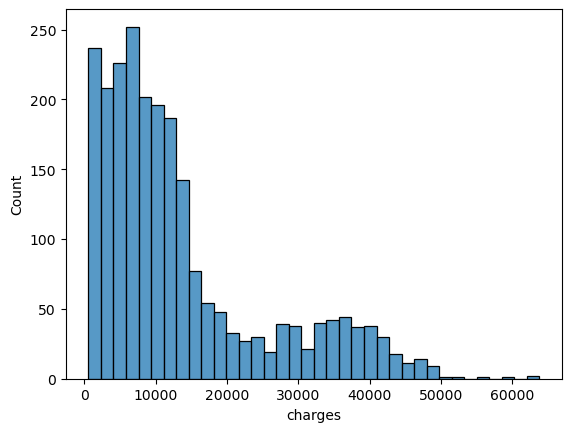

In [354]:
sns.histplot(merged_df['charges']);

### box and whisker plot using matplotlib.pyplot :

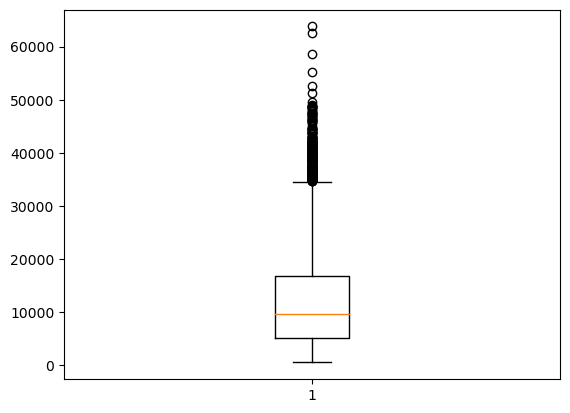

In [355]:
plt.boxplot(merged_df['charges']);

### swarm plot using seaborn :

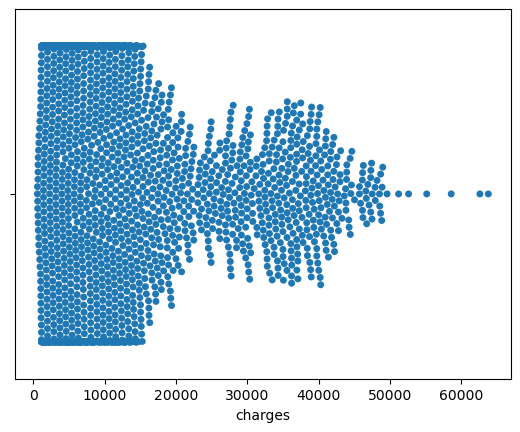

In [356]:
sns.swarmplot(merged_df['charges']);

In [357]:
merged_df.head(3)

,Customer ID,children,charges,Hospital tier,City tier,State ID,BMI,Diabetic,Heart Issues,Any Transplants,Cancer history,NumberOfMajorSurgeries,smoker,name,Year,Month,Date,Date_of_Birth,age,gender
0,Id2335,0,563.84,2,3,2,17.58,0,No,No,No,1,No,"German, Mr. Aaron K",1992,7,9,1992-07-09,32,male
1,Id2334,0,570.62,2,1,2,17.60,0,No,No,No,1,No,"Rosendahl, Mr. Evan P",1992,11,30,1992-11-30,31,male
2,Id2333,0,600.00,2,1,2,16.47,0,No,No,Yes,1,No,"Albano, Ms. Julie",1993,6,30,1993-06-30,31,female


## --Create a frequency table and a stacked bar chart to visualize the count of people in the different tiers of cities and hospitals

In [358]:
frequency_table=pd.crosstab(merged_df['City tier'],merged_df['Hospital tier'])
frequency_table

Hospital tier,1,2,3
City tier,,,
1,85,403,241
2,106,479,222
3,109,452,228


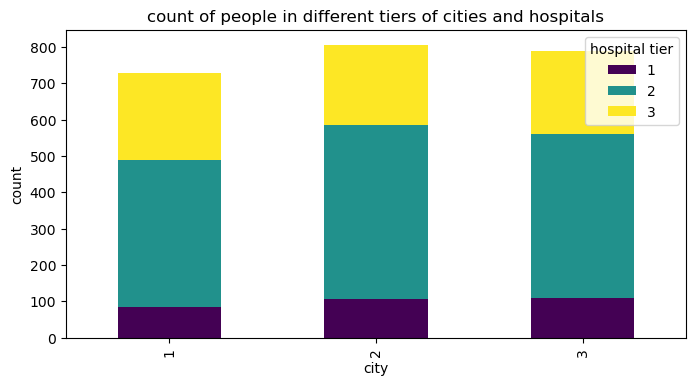

In [359]:
ax=frequency_table.plot(kind='bar',stacked=True,colormap='viridis',figsize=(8,4))
plt.xlabel('city')
plt.ylabel('count')
plt.title('count of people in different tiers of cities and hospitals')
plt.legend(title='hospital tier');

#### ** In city 2 their are more people and In city 1 their are less people

## --Test the following null hypotheses for given conditions

## a. The average hospitalization costs for the three types of hospitals are not significantly different

In [360]:
merged_df.groupby('Hospital tier')[['charges']].median()

,charges
Hospital tier,
1,32097.435
2,7168.760
3,10676.830


#### **Above, we did group by to test null hypothesis for the columns 'Hospital tier' along with 'charges' .  In statement given that The average hospitalization costs for the three types of hospitals are significantly not different but we proved that The average hospitalization costs for the three types of cities are significantly different , So null hypothesis(H0) is rejected and Alternative hypothesis(H1) is accepted.

## b. The average hospitalization costs for the three types of cities are not significantly different

In [361]:
merged_df.groupby('City tier')[['charges']].median()

,charges
City tier,
1,10027.15
2,8968.33
3,9880.07


#### **Above, we did group by to test null hypothesis for the columns 'City tier' along with 'charges' columns.  In statement given that The average hospitalization costs for the three types of cities are significantly not different as given like that The average hospitalization costs for the three types of cities are significantly not different, So  null hypothesis(H0) is accepted and Alternative hypothesis(H1) is rejected.

## c. The average hospitalization cost for smokers is not significantly different from the average cost for nonsmokers

In [362]:
merged_df.groupby('smoker')[['charges']].median()

,charges
smoker,
No,7537.160
yes,34125.475


#### **Above, we did group by to test null hypothesis for the columns 'smoker_yes' along with 'charges' columns.  In statement given that The average hospitalization costs for smokers are significantly not different from the average cost for nonsmokers but we proved that The average hospitalization costs for thesmokers are significantly different from the average cost for nonsmokers, So  null hypothesis(H0) is rejected and Alternative hypothesis(H1) is accepted.

## d. Smoking and heart issues are independent

In [363]:
merged_df.groupby('smoker')['Heart Issues'].value_counts()

smoker  Heart Issues
No      No              1108
        yes              731
yes     No               297
        yes              189
Name: Heart Issues, dtype: int64

#### ** given that Smoking and heart issues are independent but we proved Smoking and heart issues are dependent So null hypothesis(H0) is rejected and Alternative hypothesis(H1) is accepted.

## --Examine the correlation between predictors to identify highly correlated predictors. Use a heatmap to visualize this.

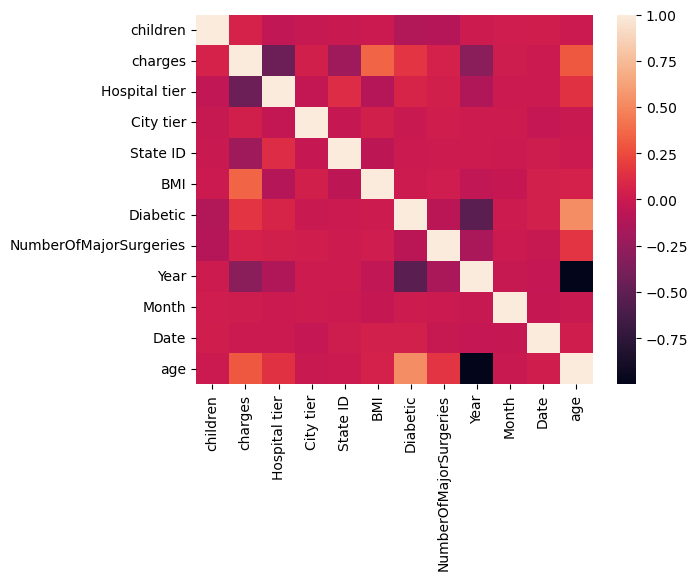

In [364]:
sns.heatmap(merged_df.corr());

#### **Correlation is high between charges and age, charges and bmi, Diabetic and age.

In [365]:
merged_df.head(2)

,Customer ID,children,charges,Hospital tier,City tier,State ID,BMI,Diabetic,Heart Issues,Any Transplants,Cancer history,NumberOfMajorSurgeries,smoker,name,Year,Month,Date,Date_of_Birth,age,gender
0,Id2335,0,563.84,2,3,2,17.58,0,No,No,No,1,No,"German, Mr. Aaron K",1992,7,9,1992-07-09,32,male
1,Id2334,0,570.62,2,1,2,17.60,0,No,No,No,1,No,"Rosendahl, Mr. Evan P",1992,11,30,1992-11-30,31,male


#### **Deleting unwanted columns

In [366]:
merged_df=merged_df.drop(columns=['Customer ID','name','Year','Month','Date','Date_of_Birth'])

## -- Use the necessary transformation methods to deal with the nominal and ordinal categorical variables in the dataset 

In [367]:
merged_df=pd.get_dummies(merged_df,columns=['Heart Issues','Any Transplants','Cancer history','smoker','gender'],drop_first=True)

In [370]:
merged_df.head()

,children,charges,Hospital tier,City tier,State ID,BMI,Diabetic,NumberOfMajorSurgeries,age,Heart Issues_yes,Any Transplants_yes,Cancer history_Yes,smoker_yes,gender_male
0,0,563.84,2,3,2,17.58,0,1,32,0,0,0,0,1
1,0,570.62,2,1,2,17.60,0,1,31,0,0,0,0,1
2,0,600.00,2,1,2,16.47,0,1,31,0,0,1,0,0
3,0,604.54,3,3,2,17.70,0,1,31,0,0,0,0,1
4,0,637.26,3,3,2,22.34,0,1,26,0,0,0,0,1


In [371]:
merged_df.isnull().sum()

children                  0
charges                   0
Hospital tier             0
City tier                 0
State ID                  0
BMI                       0
Diabetic                  0
NumberOfMajorSurgeries    0
age                       0
Heart Issues_yes          0
Any Transplants_yes       0
Cancer history_Yes        0
smoker_yes                0
gender_male               0
dtype: int64

## --Develop and evaluate the final model using regression with a stochastic gradient descent optimizer. 

In [396]:
from sklearn.model_selection import KFold,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

## --Use standardization 

#### **Using StandardScaler for the columns which contain values in much different compare with other elememts. so to bring values in a  similar range StandardScaler is being used.

In [373]:
cols_to_scale=['BMI','age','charges']

In [374]:
scaler=StandardScaler()

In [375]:
merged_df[cols_to_scale]=scaler.fit_transform(merged_df[cols_to_scale])

In [376]:
merged_df.head(5)

,children,charges,Hospital tier,City tier,State ID,BMI,Diabetic,NumberOfMajorSurgeries,age,Heart Issues_yes,Any Transplants_yes,Cancer history_Yes,smoker_yes,gender_male
0,0,-1.092478,2,3,2,-1.534432,0,1,-0.640972,0,0,0,0,1
1,0,-1.091907,2,1,2,-1.532145,0,1,-0.715650,0,0,0,0,1
2,0,-1.089430,2,1,2,-1.661390,0,1,-0.715650,0,0,1,0,0
3,0,-1.089047,3,3,2,-1.520707,0,1,-0.715650,0,0,0,0,1
4,0,-1.086288,3,3,2,-0.990000,0,1,-1.089036,0,0,0,0,1


#### **Now the values are in same range.

#### **splitting data in x and y variables to train and test

In [397]:
x=merged_df.drop(['charges'],axis=1)
y=merged_df.charges

## --Use random forest and extreme gradient boosting for cost prediction, share your cross validation results, and calculate variable importance scores

### random forest:

In [398]:
# random forest model
rf_model=RandomForestRegressor(n_estimators=100,max_depth=5,random_state=42)

# cross validation results for random forest
scores=cross_val_score(rf_model,x,y,cv=5,scoring='neg_root_mean_squared_error')

mean_rmse=np.sqrt(-scores)

print('Random Forest cross validation results:')
print('RMSE Scores:',scores)
print('Average RMSE:',np.mean(mean_rmse))


# fit random forest model on the entire dataset for variable impotance
rf_model.fit(x,y)

rf_feature_importance=rf_model.feature_importances_
rf_importance_df=pd.DataFrame({'Feature':x.columns,'Importance':rf_feature_importance})
rf_importance_df=rf_importance_df.sort_values(by='Importance',ascending=False)
rf_importance_df

Random Forest cross validation results:
RMSE Scores: [-0.52627758 -0.37240999 -0.41634145 -0.6087366  -1.59116409]
Average RMSE: 0.804515695612346


,Feature,Importance
11,smoker_yes,0.769578
4,BMI,0.110594
7,age,0.086369
1,Hospital tier,0.014220
0,children,0.009694
3,State ID,0.009066
10,Cancer history_Yes,0.000152
2,City tier,0.000098
6,NumberOfMajorSurgeries,0.000068
8,Heart Issues_yes,0.000055


### extreme gradient boosting:

In [399]:
# random forest model
xgb_model=XGBRegressor(n_estimators=100,max_depth=5,random_state=42)

# cross validation results for random forest
scores=cross_val_score(xgb_model,x,y,cv=5,scoring='neg_root_mean_squared_error')

mean_rmse=np.sqrt(-scores)

print('xgboost cross validation results:')
print('RMSE Scores:',scores)
print('Average RMSE:',np.mean(mean_rmse))


# fit xgboost model on the entire dataset for variable impotance
xgb_model.fit(x,y)

xgb_feature_importance=xgb_model.feature_importances_
xgb_importance_df=pd.DataFrame({'Feature':x.columns,'Importance':xgb_feature_importance})
xgb_importance_df=xgb_importance_df.sort_values(by='Importance',ascending=False)
xgb_importance_df

xgboost cross validation results:
RMSE Scores: [-0.93281775 -0.37481041 -0.47173591 -0.67959402 -1.57027087]
Average RMSE: 0.8684704545515398


,Feature,Importance
11,smoker_yes,0.917777
7,age,0.020136
4,BMI,0.017776
1,Hospital tier,0.011808
3,State ID,0.006616
0,children,0.006573
12,gender_male,0.005731
10,Cancer history_Yes,0.003387
8,Heart Issues_yes,0.002777
6,NumberOfMajorSurgeries,0.002118


#### **Average RMSE of random forest model is 0.8041491006399605 and Average RMSE of xgboost model is 0.8645686797212473 So we got  Average RMSE of xgboost model  is greater than  Average RMSE of random forest model.

### ** Random forest model is predicting better than xgboost model and stochastic gradient descent optimizer.**